In [1]:
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
import cv2
import os

In [2]:
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


In [3]:
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

def check_again(video_file_path):
  
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_hands = mp.solutions.hands
  cap = cv2.VideoCapture(video_file_path)
  arr_res_finger_first = [] #4
  arr_res_finger_fourth = [] #5,6
  
  with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
      
      success, image = cap.read()
      if not success:
        print("Ignoring empty camera frame.") 
        break;
 
      image.flags.writeable = False
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      results = hands.process(image)

      # Draw the hand annotations on the image.
      image.flags.writeable = True
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      enum_finger_thumb = 4
      enum_finger_second= 6
      

      arr_res_finger_first.append(results.multi_hand_landmarks[0].landmark[enum_finger_thumb].z)
      arr_res_finger_fourth.append(results.multi_hand_landmarks[0].landmark[enum_finger_second].z)

      cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
      if cv2.waitKey(5) & 0xFF == 27:
        break
  #print(arr_res_finger_first)
  #print(arr_res_finger_fourth)
  i = 0
  thumb_down_score = 0
  thumb_up_score =  0
  for a in arr_res_finger_first:
    i=i+1
    if arr_res_finger_fourth[i] - arr_res_finger_first[i] > 5:
      thumb_down_score += 1
    elif arr_res_finger_fourth[i] - arr_res_finger_first[i] < -1:
      thumb_up_score += 1
  
  plt.title("Line graph")
  plt.plot(arr_res_finger_first, color="blue")
  plt.plot(arr_res_finger_fourth, color="red")
  
  plt.show()
  
  res = 0
  
  if thumb_down_score > thumb_up_score : res = 1
  elif thumb_down_score < thumb_up_score : res = 0
  return res

 

In [4]:

def do_process(video_file_path):
  print(video_file_path)

  import math
  import cv2

  import mediapipe as mp
  from mediapipe.tasks import python
  from mediapipe.tasks.python import vision
  from mediapipe.python import packet_creator
  from mediapipe.python import packet_getter

  from mediapipe.python._framework_bindings import calculator_graph
  from mediapipe.python._framework_bindings import image
  from mediapipe.python._framework_bindings import image_frame
  from mediapipe.python._framework_bindings import packet

  CalculatorGraph = calculator_graph.CalculatorGraph
  Image = image.Image
  ImageFormat = image_frame.ImageFormat
  ImageFrame = image_frame.ImageFrame

  # STEP 2: Create an GestureRecognizer object.
  VisionRunningMode = mp.tasks.vision.RunningMode
  base_options = python.BaseOptions(model_asset_path='/Users/s/dacon/gesture_recognizer.task')
  options = vision.GestureRecognizerOptions(base_options=base_options, running_mode=VisionRunningMode.VIDEO )
  recognizer = vision.GestureRecognizer.create_from_options(options)

  results = []
  
  cap = cv2.VideoCapture(video_file_path)
  fps = cv2.CAP_PROP_FPS
  calc_timestamps = [0.0]

  res_landmark = []
  res_not_found_count = 0
  
  ret = True
  while ret:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret:      
      ts = cap.get(cv2.CAP_PROP_POS_MSEC)      
      cts = calc_timestamps[-1] + 1000/fps
      #print(abs(ts-cts))
      recognition_result =recognizer.recognize_for_video( mp.Image(image_format=ImageFormat.SRGB, data=img), int(ts))
      try : 
        top_gesture = recognition_result.gestures[0][0]        
        hand_landmarks = top_gesture.category_name
        #print(hand_landmarks)
        results.append(top_gesture)
        res_landmark.append(hand_landmarks)
      except IndexError: 
        res_landmark.append('-')
        res_not_found_count += 1
        continue
      
  cap.release()
  cv2.destroyAllWindows
  res = -1
  
  if res_landmark.count('-') == len(res_landmark) :
    print("None!")
    res = check_again(video_file_path)
  else:    
    print(res_landmark)    
    if res_landmark.count('Open_Palm') > 10 : 
      res = 4 # Open_palm
  return res


./open/train/TRAIN_000.mp4
None!


W20230205 23:52:37.271409 370468352 gesture_recognizer_graph.cc:121] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleartion to Xnnpack.
I20230205 23:52:37.272728 370468352 hand_gesture_recognizer_graph.cc:249] Custom gesture classifier is not defined.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
OpenCV: Couldn't read video stream from file "./open/train/TRAIN_000.mp4"
OpenCV: Couldn't read video stream from file "./open/train/TRAIN_000.mp4"


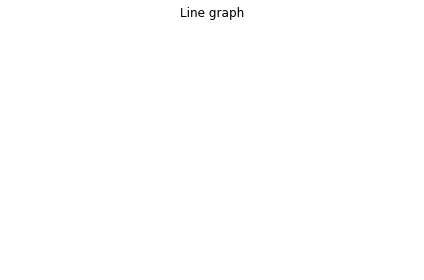

In [5]:
def main2():
    file_index = ''
    for i in range(0, 1): 
        if i < 10 : file_index = '00'+str(i)
        elif i> 10 and i<100: file_index= '0'+str(i)
        else: file_index = str(i)
        video_file_path = './open/train/TRAIN_'+file_index + '.mp4'
        
        do_process(video_file_path)
        
import pandas as pd
import os 

def main():
  res_true = 0
  res_false= 0
  df = pd.read_csv('/Users/s/dacon/open/train.csv')
  

  for row in df.iterrows():
    print(row[1].path)
            
    if do_process(row[1].path) == row[1].label:
      res_true +=1
    else:
      res_false += 1
      
if __name__ == "__main__":
  main2()
 
    #print(res_not_found_count)
    #print(res_landmark.count('Open_Palm'))
    #print(results)
    
#  display_batch_of_images_with_gestures_and_hand_landmarks(images, results)
